In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
# from devtools import pprint
# from rich import print
from tqdm import tqdm

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

In [3]:
# pip install --upgrade ewatercycle

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/nbs_31_normal vs da/Forcing')

Simple example using HBV:

In [5]:
from ewatercycle.forcing import sources

In [6]:
from ewatercycle_DA import DA

In [7]:
import ewatercycle_DA

In [8]:
n_particles = 500

In [9]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [10]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5, 0])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

In [11]:
from ewatercycle_DA.local_models.HBV import HBVLocal

In [100]:
experiment_start_date = "1997-08-01T00:00:00"
experiment_end_date = "2000-08-01T00:00:00"
experiment_end_ts = pd.Timestamp(experiment_end_date) - pd.Timedelta(1,"d")
alpha = 1.26

In [102]:
dt_time_cal = pd.date_range(experiment_start_date, experiment_end_ts)
time_cal = [pd.Timestamp(timestamp) for timestamp in dt_time_cal]

In [87]:
HRU_ids = [path.name[1:8] for path in  forcing_path.glob("*.txt")]

In [145]:
HRU_ids

['1195100',
 '1142500',
 '1022500',
 '1121000',
 '1170100',
 '1139800',
 '4296000',
 '1134500',
 '1030500',
 '1073000',
 '1169000',
 '1144000',
 '1137500',
 '1118300',
 '1047000',
 '1078000',
 '1181000',
 '1057000',
 '1187300',
 '1162500',
 '1052500',
 '1123000',
 '1054200',
 '1031500',
 '1139000',
 '1055000',
 '1150900',
 '1013500']

In [142]:
run_hru_ids = HRU_ids[:7]

In [143]:
ensemble_members_path = list(output_path.glob("nse*.txt"))
files = list(output_path.glob("state_vectors_*.txt"))

# Validation

In [112]:
def run_val(optimal_params, final_storage, HRU_id):
    experiment_start_date = "2000-08-01T00:00:00Z"
    experiment_end_date = "2003-08-01T00:00:00Z"
    alpha = 1.26
    camels_forcing_validation = sources.HBVForcing(start_time = experiment_start_date,
                              end_time = experiment_end_date,
                              directory = forcing_path,
                              camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                              alpha = alpha,
                              )
    validation_model = HBVLocal(forcing=camels_forcing_validation)
    config_file, _ = validation_model.setup(
                parameters=','.join([str(p) for p in optimal_params]),
                initial_storage=','.join([str(s) for s in final_storage]),
               )
    validation_model.initialize(config_file)
    
    Q_m_val = []
    time_val = []
    while validation_model.time < validation_model.end_time:
        time_val.append(validation_model.time_as_datetime.date())
        validation_model.update()
        Q_m_val.append(validation_model.get_value("Q"))
    
    validation_model.finalize()
    
    ds = xr.open_dataset(forcing_path / validation_model.forcing.pr)
    observations = observations_path / f'0{HRU_id}_streamflow_qc.txt'
    cubic_ft_to_cubic_m = 0.0283168466 
    new_header = ['GAGEID','Year','Month', 'Day', 'Streamflow(cubic feet per second)','QC_flag']
    new_header_dict = dict(list(zip(range(len(new_header)),new_header)))
    
    df_Q = pd.read_fwf(observations,delimiter=' ',encoding='utf-8',header=None)
    df_Q = df_Q.rename(columns=new_header_dict)
    df_Q['Streamflow(cubic feet per second)'] = df_Q['Streamflow(cubic feet per second)'].apply(lambda x: np.nan if x==-999.00 else x)
    df_Q['Q (m3/s)'] = df_Q['Streamflow(cubic feet per second)'] * cubic_ft_to_cubic_m
    df_Q['Q'] = df_Q['Q (m3/s)'] / ds.attrs['area basin(m^2)'] * 3600 * 24 * 1000 # m3/s -> m/s ->m/d -> mm/d
    ds.close()
    df_Q.index = df_Q.apply(lambda x: pd.Timestamp(f'{int(x.Year)}-{int(x.Month)}-{int(x.Day)}'),axis=1)
    df_Q.index.name = "time"
    df_Q.drop(columns=['Year','Month', 'Day','Streamflow(cubic feet per second)'],inplace=True)
    df_Q = df_Q.dropna(axis=0)
    
        
        
    df_Q_val= df_Q.loc[time_val]
    nse_val = calc_NSE(df_Q_val['Q'].values,np.array(Q_m_val).flatten())

    return time_val, Q_m_val, nse_val, df_Q

In [130]:
def plot(HRU_ID):
    state_vector_file = np.array(files)[[(HRU_ID in str(file)) for file in files]]
    ensemble_members_file = np.array(ensemble_members_path)[[(HRU_ID in str(file)) for file in ensemble_members_path]]
    state_vector = np.loadtxt(state_vector_file[0])
    optimal_params = state_vector[:9]
    final_storage = state_vector[9:-1]
    ensemble_members = np.loadtxt(ensemble_members_file[0])
    df_ensemble_run = pd.DataFrame(data=ensemble_members,index=time_cal,columns=["Q"])
    
    time_val, Q_m_val, nse_val, df_Q = run_val(optimal_params, final_storage, HRU_ID)

    df_Q_Cal = df_Q.loc[time_cal]
    df_Q_val= df_Q.loc[time_val]
    nse_cal = calc_NSE(df_Q_Cal['Q'].values, ensemble_members)
    
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    df_ensemble_run.plot(ax=ax,color="C1",label="Model callibration")
    df_Q_Cal['Q'].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations Callibration",color='grey')
    ax.plot(time_val, Q_m_val,label="Model Vallidation");
    df_Q_val['Q'].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations Vallidation",color='k')
    ax.legend();
    plt.title(f'Callibration (NSE = {nse_cal:.2f}) and Validation (NSE = {nse_val:.2f}) for HRU ID{HRU_ID}');

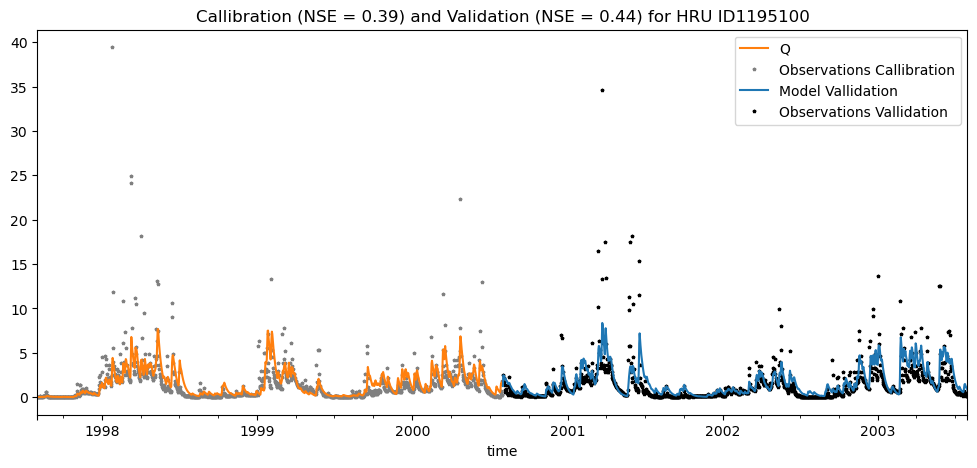

In [131]:
plot(run_hru_ids[0])

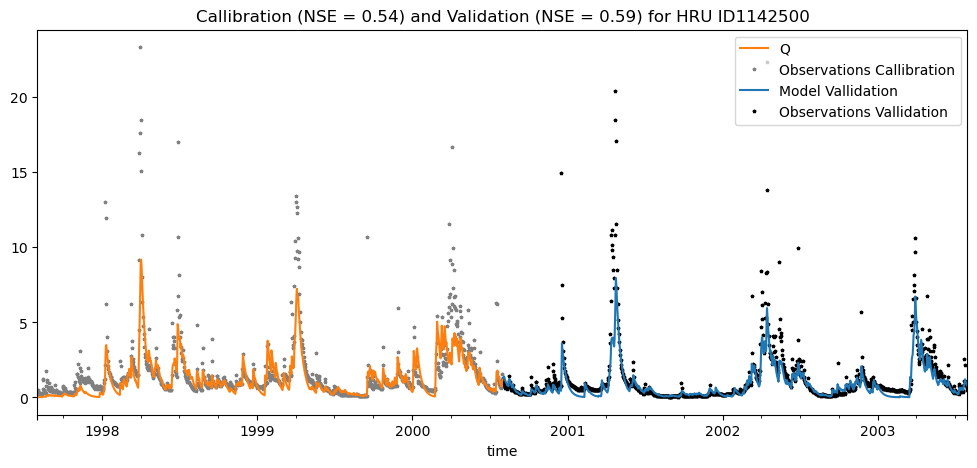

In [132]:
plot(run_hru_ids[1])

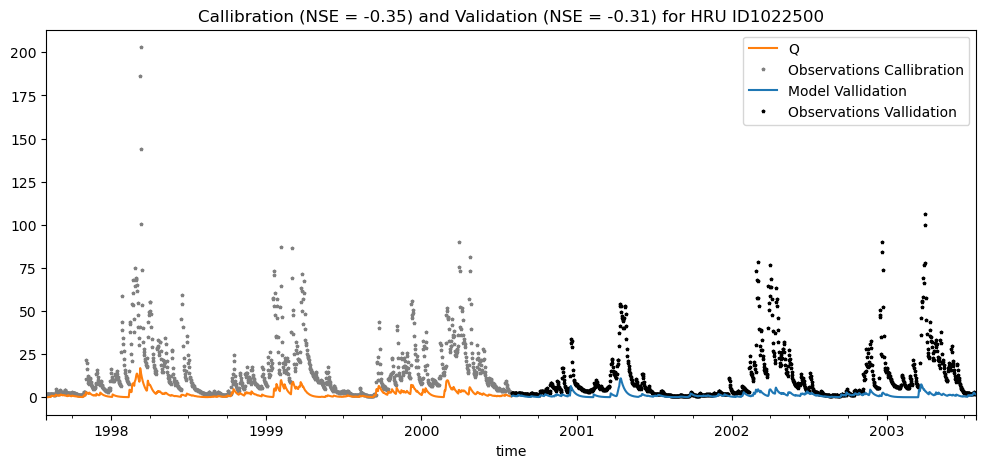

In [133]:
plot(run_hru_ids[2])

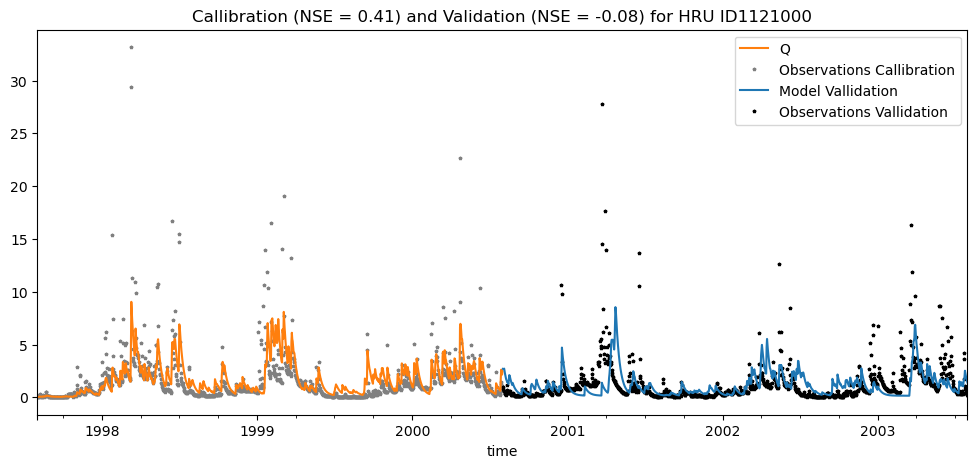

In [134]:
plot(run_hru_ids[3])

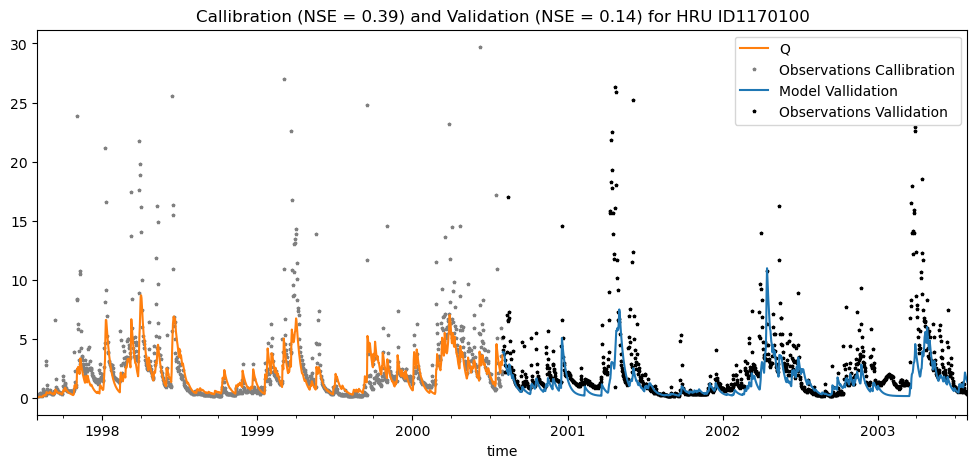

In [135]:
plot(run_hru_ids[4])

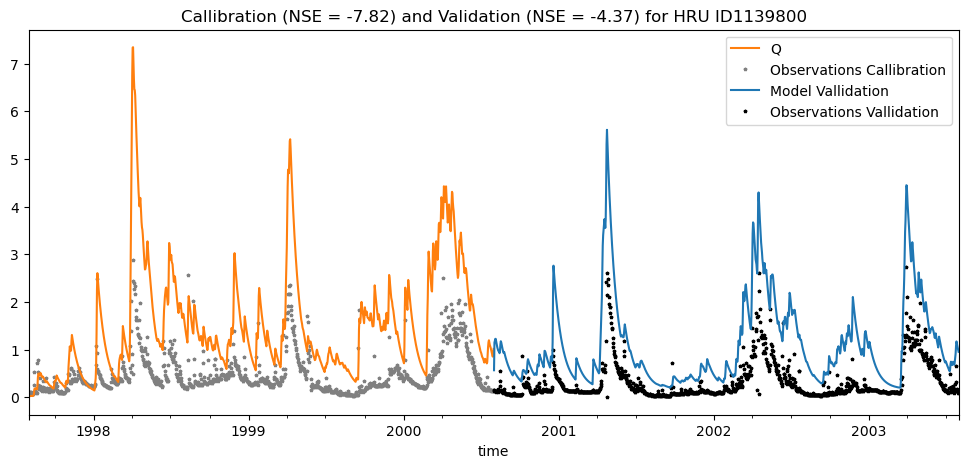

In [136]:
plot(run_hru_ids[5])

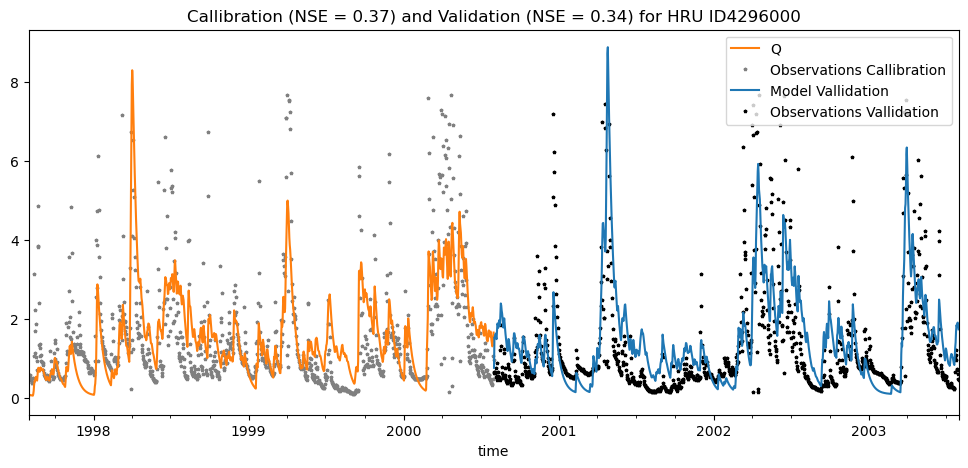

In [144]:
plot(run_hru_ids[6])